In [4]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [8]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

In [9]:

train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [10]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


In [12]:

unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [15]:
max_epochs = 20 if not os.getenv("CI", False) else 2
batch_size = 1024
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=1,
                       optimizer_fn=torch.optim.Adam, # Any optimizer works here
                       optimizer_params=dict(lr=2e-2),
                       scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
                       scheduler_params={"is_batch_level":True,
                                         "max_lr":5e-2,
                                         "steps_per_epoch":int(train.shape[0] / batch_size)+1,
                                         "epochs":max_epochs
                                          },
                       mask_type='entmax', # "sparsemax",
                      )

Device used : cuda


In [16]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [11]:
def my_loss_fn(y_pred, y_true):
    """
    Dummy example similar to using default torch.nn.functional.cross_entropy
    """
    softmax_pred = torch.nn.Softmax(dim=-1)(y_pred)
    logloss = (1-y_true)*torch.log(softmax_pred[:,0])
    logloss += y_true*torch.log(softmax_pred[:,1])
    return -torch.mean(logloss)

In [12]:
from pytorch_tabnet.metrics import Metric

In [13]:
class my_metric(Metric):
    """
    2xAUC.
    """

    def __init__(self):
        self._name = "custom" # write an understandable name here
        self._maximize = True

    def __call__(self, y_true, y_score):
        """
        Compute AUC of predictions.

        Parameters
        ----------
        y_true: np.ndarray
            Target matrix or vector
        y_score: np.ndarray
            Score matrix or vector

        Returns
        -------
            float
            AUC of predictions vs targets.
        """
        return 2*roc_auc_score(y_true, y_score[:, 1])

In [14]:

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'val'],
    eval_metric=["auc", my_metric],
    max_epochs=max_epochs , patience=0,
    batch_size=batch_size,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    loss_fn=my_loss_fn
)

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.95035 | train_auc: 0.60503 | train_custom: 1.21006 | val_auc: 0.61156 | val_custom: 1.22313 |  0:00:01s
epoch 1  | loss: 0.64614 | train_auc: 0.7274  | train_custom: 1.4548  | val_auc: 0.71625 | val_custom: 1.43251 |  0:00:02s
epoch 2  | loss: 0.57011 | train_auc: 0.78408 | train_custom: 1.56816 | val_auc: 0.77706 | val_custom: 1.55412 |  0:00:04s
epoch 3  | loss: 0.51067 | train_auc: 0.83406 | train_custom: 1.66813 | val_auc: 0.83424 | val_custom: 1.66848 |  0:00:05s
epoch 4  | loss: 0.45517 | train_auc: 0.87221 | train_custom: 1.74443 | val_auc: 0.87191 | val_custom: 1.74382 |  0:00:06s
epoch 5  | loss: 0.40843 | train_auc: 0.89726 | train_custom: 1.79452 | val_auc: 0.89884 | val_custom: 1.79769 |  0:00:07s
epoch 6  | loss: 0.38581 | train_auc: 0.90519 | train_custom: 1.81038 | val_auc: 0.90176 | val_custom: 1.80351 |  0:00:09s
epoch 7  | loss: 0.37916 | train_auc: 0.90912 | train_custom: 1.81

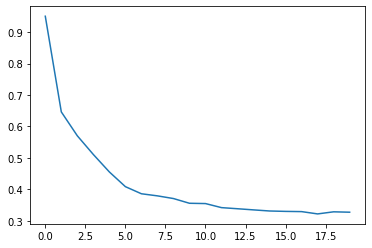

In [15]:
plt.plot(clf.history['loss'])

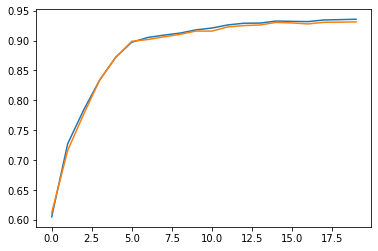

In [16]:
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['val_auc'])

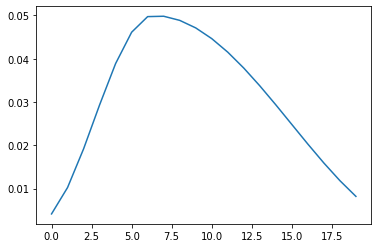

In [17]:
# plot learning rates
plt.plot(clf.history['lr'])

In [18]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)

preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)


print(f"FINAL VALID SCORE FOR {dataset_name} : {clf.history['val_auc'][-1]}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

FINAL VALID SCORE FOR census-income : 0.9313053632425361
FINAL TEST SCORE FOR census-income : 0.9284385971188095


In [19]:
clf.feature_importances_

array([0.09305932, 0.02292801, 0.01782496, 0.04211545, 0.04599311,
       0.13450468, 0.08962488, 0.0388393 , 0.01481395, 0.03064817,
       0.28628697, 0.14016918, 0.03022194, 0.01297008])

In [20]:
explain_matrix, masks = clf.explain(X_test)

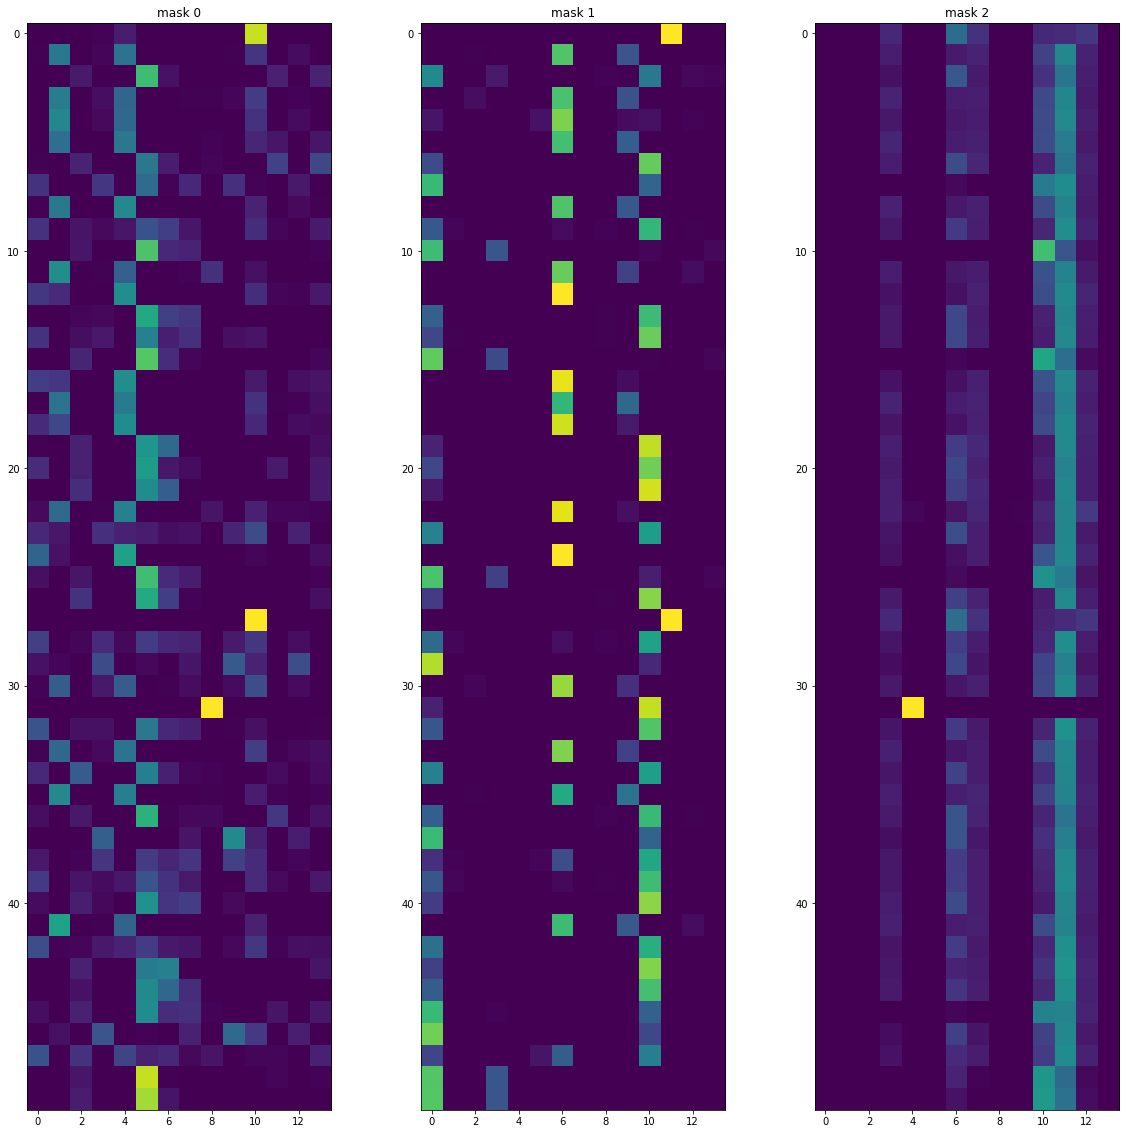

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [29]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-error:0.13784
Will train until validation_0-error hasn't improved in 40 rounds.
[10]	validation_0-error:0.12915
[20]	validation_0-error:0.12667
[30]	validation_0-error:0.12481
[40]	validation_0-error:0.12481
[50]	validation_0-error:0.12419
[60]	validation_0-error:0.12419
[70]	validation_0-error:0.12419
[80]	validation_0-error:0.12449
[90]	validation_0-error:0.12325
[100]	validation_0-error:0.12201
[110]	validation_0-error:0.12170
[120]	validation_0-error:0.12201
[130]	validation_0-error:0.12232
[140]	validation_0-error:0.12294
Stopping. Best iteration:
[103]	validation_0-error:0.12108



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
              subsample=0.7, tree_method='exact', validate_parameters=1,
              verbosity=0)

In [30]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print(test_auc)

0.9335963387010509
0.9243623615745874
